In [15]:

import sys
sys.path.append('..')

import torch
from src.models.autoencoder import BasicAutoencoderKL
import numpy as np

ddconfig = {
    "double_z": True,
    "z_channels": 4,
    "resolution": 512,
    "in_channels": 5,
    "out_ch": 5,
    "ch": 128,
    "ch_mult": [1, 2, 4, 8],
    "num_res_blocks": 2,
    "attn_resolutions": [],
    "dropout": 0.0
}

lossconfig = {"target": "torch.nn.Identity"}

vae = BasicAutoencoderKL(
    ddconfig=ddconfig,
    lossconfig=lossconfig,
    embed_dim=4,
    ckpt_path="../models/vae/vae.ckpt"  # Using the provided checkpoint path
)
vae.eval()  # Set to evaluation mode

making attention of type 'vanilla' with 1024 in_channels
Working with z of shape (1, 4, 64, 64) = 16384 dimensions.
making attention of type 'vanilla' with 1024 in_channels


/Users/lapuerta/aicell/cell-diffusion/notebooks/../src/models/autoencoder.py:1183: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(path, map_location="

Restored VAE from ../models/vae/vae.ckpt


BasicAutoencoderKL(
  (encoder): Encoder(
    (conv_in): Conv2d(5, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (down): ModuleList(
      (0): Module(
        (block): ModuleList(
          (0-1): 2 x ResnetBlock(
            (norm1): GroupNorm(32, 128, eps=1e-06, affine=True)
            (conv1): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
            (norm2): GroupNorm(32, 128, eps=1e-06, affine=True)
            (dropout): Dropout(p=0.0, inplace=False)
            (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          )
        )
        (attn): ModuleList()
        (downsample): Downsample(
          (conv): Conv2d(128, 128, kernel_size=(3, 3), stride=(2, 2))
        )
      )
      (1): Module(
        (block): ModuleList(
          (0): ResnetBlock(
            (norm1): GroupNorm(32, 128, eps=1e-06, affine=True)
            (conv1): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          

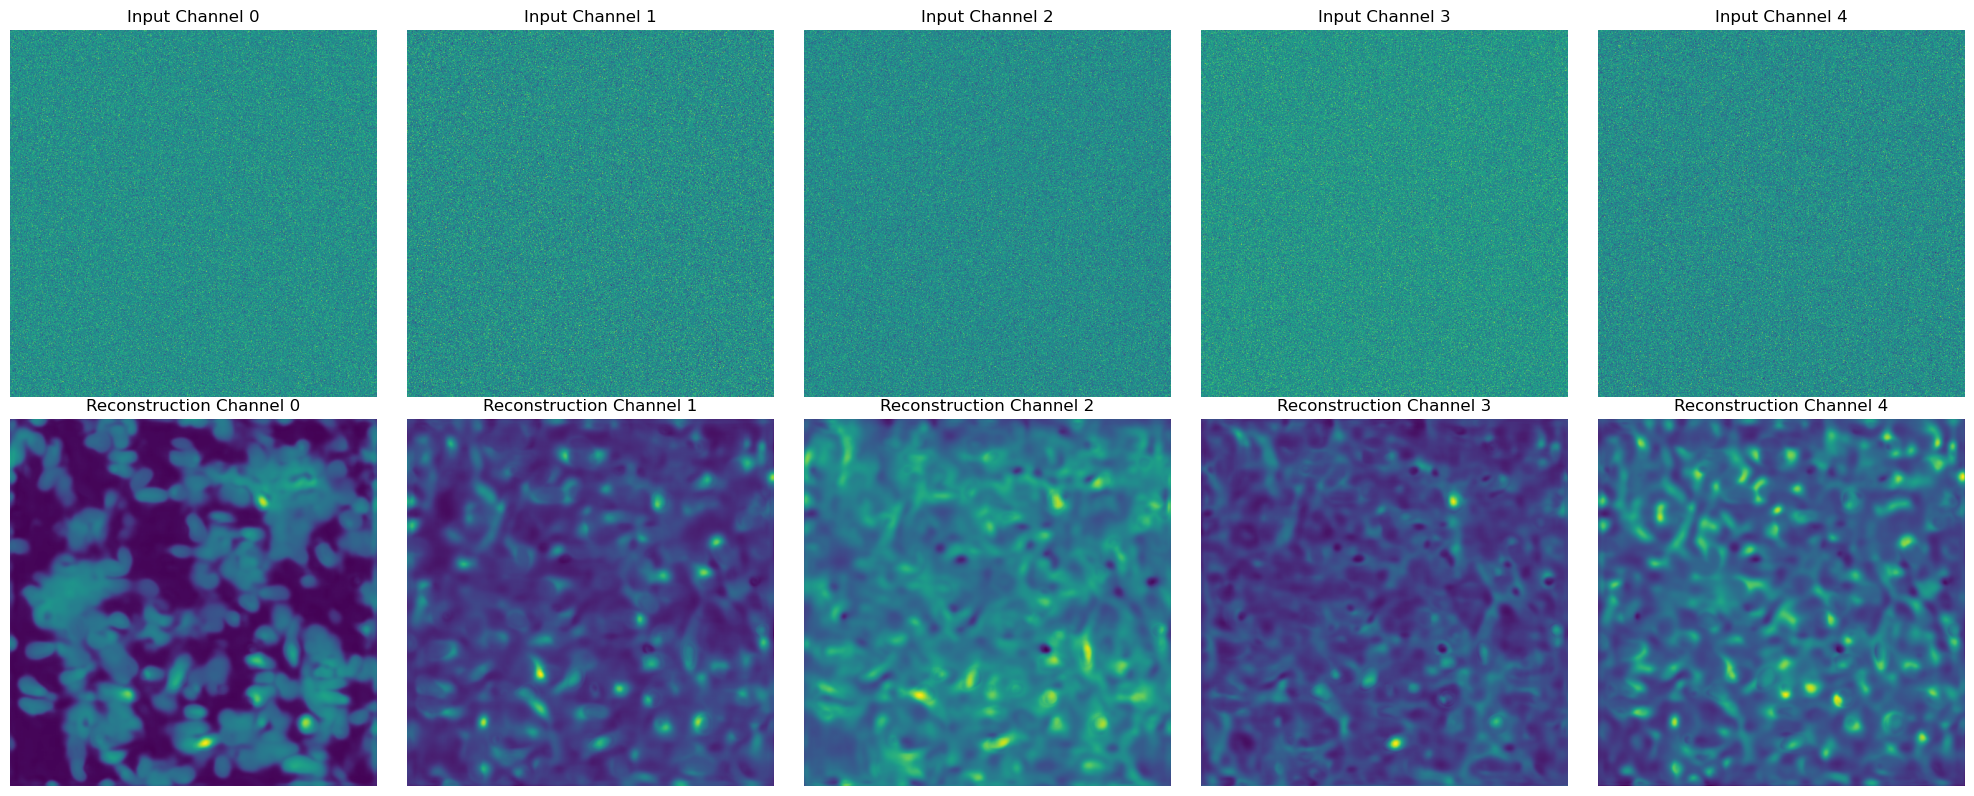

In [16]:
import matplotlib.pyplot as plt
# Create a sample input (batch_size=1, channels=5, height=512, width=512)
sample_input = torch.randn(1, 5, 512, 512)

with torch.no_grad():
    posterior = vae.encode(sample_input)
    latents = posterior.sample()
    reconstruction = vae.decode(latents)

    # Create a figure with 5 columns (one per channel) and 2 rows (input/output)
    plt.figure(figsize=(20, 8))
    
    for i in range(5):
        # Plot original channel
        plt.subplot(2, 5, i + 1)
        plt.imshow(sample_input[0, i].numpy())
        plt.title(f'Input Channel {i}')
        plt.axis('off')
        
        # Plot reconstructed channel
        plt.subplot(2, 5, i + 6)
        plt.imshow(reconstruction[0, i].numpy())
        plt.title(f'Reconstruction Channel {i}')
        plt.axis('off')
    
    plt.tight_layout()
    plt.show()

In [17]:
import webdataset as wds
import matplotlib.pyplot as plt
import torch


def show_vae_reconstruction(n=0):
    """
    Show VAE reconstruction for the nth sample from the webdataset.
    
    Args:
        n (int): Index of the sample to show (default: 0)
    """
    # Setup webdataset
    WDS_DIR = "../data/webdataset"  # Adjust path as needed
    val_pattern = f"{WDS_DIR}/val/shard_{{000001..999999}}.tar"
    dataset = wds.WebDataset(val_pattern).decode()
    
    # Get nth sample
    for i, sample in enumerate(dataset):
        if i == n:
            break
    
    with torch.no_grad():
        plt.figure(figsize=(20, 8))
        
        # Prepare input
        images = torch.from_numpy(sample['images.npy']).unsqueeze(0)
        
        # Get VAE reconstruction
        posterior = vae.encode(images)
        latents = posterior.sample()
        reconstruction = vae.decode(latents)
        
        # Plot all channels
        for i in range(5):
            # Plot original channel
            plt.subplot(2, 5, i + 1)
            plt.imshow(images[0, i].numpy(), cmap='gray', vmin=0, vmax=1)
            plt.title(f'Input Channel {i}')
            plt.axis('off')
            
            # Plot reconstructed channel
            plt.subplot(2, 5, i + 6)
            plt.imshow(reconstruction[0, i].numpy(), cmap='gray', vmin=0, vmax=1)
            plt.title(f'Reconstruction Channel {i}')
            plt.axis('off')
        
        plt.tight_layout()
        plt.show()
        
        # Print metadata if available
        if 'meta.json' in sample:
            print("\nMetadata:")
            for k, v in sample['meta.json'].items():
                if v is not None:  # Only show non-None values
                    print(f"{k}: {v}")

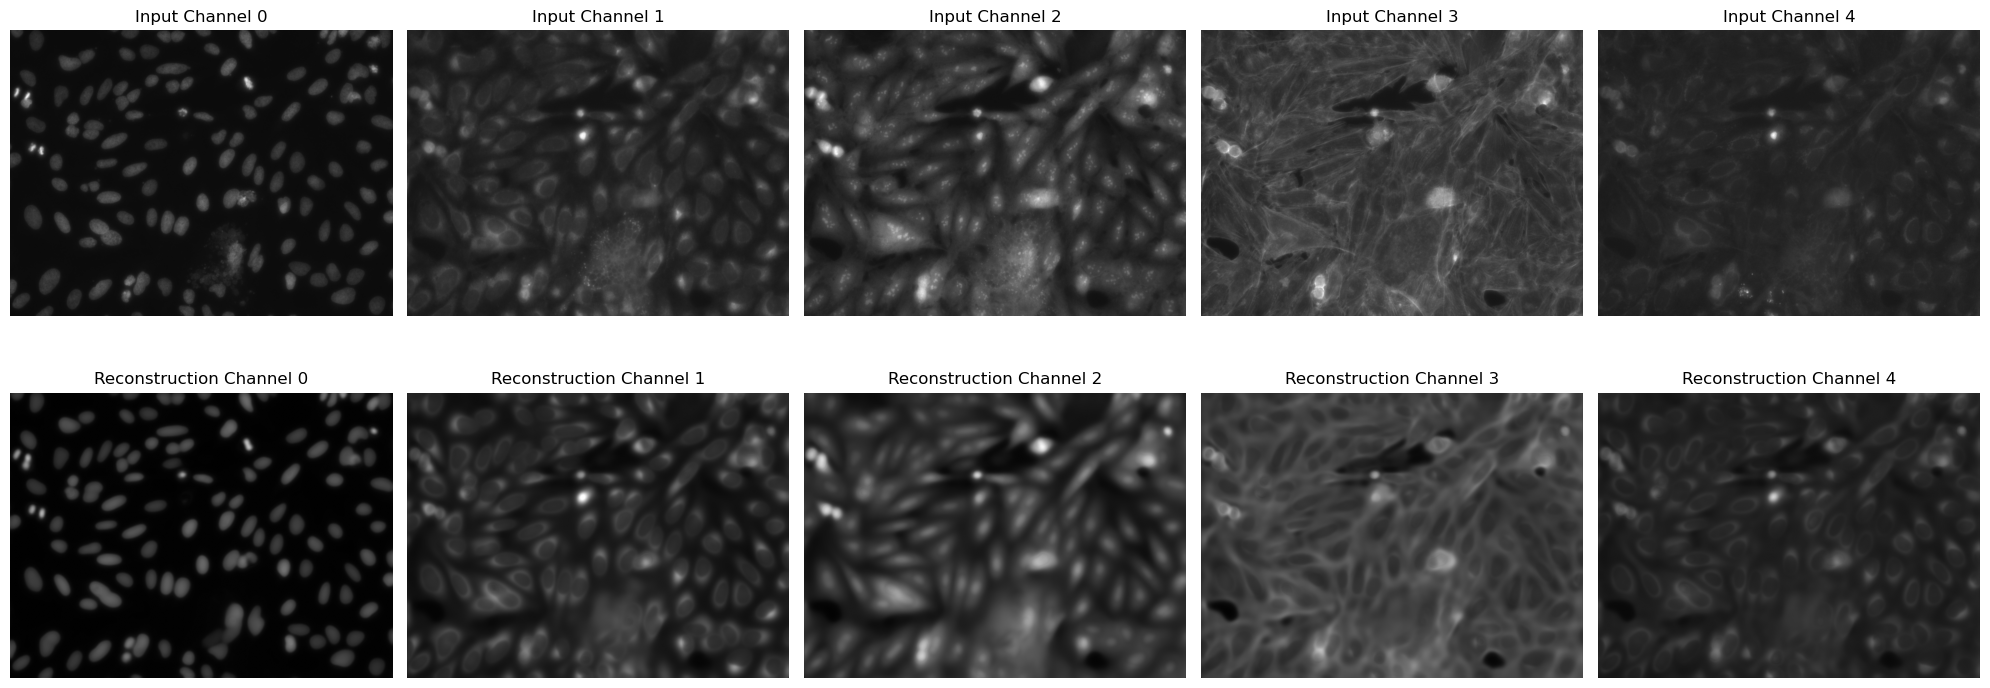


Metadata:
broad_id: BRD-K31678817-001-02-0
compound_name: isobergaptene
compound_type: primary-common
smiles: COc1cc2occc2c2oc(=O)ccc12
plate_id: 24277
well: J01
site: 1


In [18]:
show_vae_reconstruction(10)